<h1>The Perfect Neighborhood</h1>

<h3>Installing and importing libraries</h3>

In [1]:
!pip install bs4
!pip install requests
!pip install html5lib
!pip install folium

  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 92kB 7.9MB/s eta 0:00:011


In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
from IPython.display import HTML
import base64  
import pandas as pd 
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_similarity_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
import random as r
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

<h3>Defining some functions</h3>

In [3]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

#create_download_link(df_new)

In [4]:
#Get Latitude and longitude values of Neighborhood
def getCoordinates(neigh):
    address = '{}, Toronto'.format(neigh)
    geolocator = Nominatim(user_agent="t_explorer")
    latLong = geolocator.geocode(address)
    latLong = [latLong.latitude, latLong.longitude]
    return latLong

In [5]:
#Function to get URL for each neighborhood (explore)

LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1000 # Radius of Search

def getURL(lat, long):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    return url

In [6]:
#function to generate random colors
def randomColor():
    colorArr = ['00','11','22','33','44','55','66','77','88','99','AA','BB','CC','DD','EE','FF']
    color = '#' + colorArr[r.randint(0,15)] + colorArr[r.randint(0,15)] + colorArr[r.randint(0,15)]
    return color

<h3>Get toronto neighborhood data from wikipedia</h3>

In [7]:
#Link of wikipedia Pages for Toronto Postal codes
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
webpage = requests.get(URL) 

In [8]:
#Covert page to BeautifulSoup Object and extract the table
soup = BeautifulSoup(webpage.content, 'html5lib') 
table = soup.find('tbody')

In [60]:
#Load table data to a dataframe
postalArr = []
boroughArr = []
hoodArr = []

for ind, row in enumerate(table.findAll('tr')):
    if (ind == 0):
        continue
    else:
        postalArr.append(row.findChildren()[0].text[:-1])
        boroughArr.append(row.findChildren()[1].text[:-1])
        hoodArr.append(row.findChildren()[2].text[:-1])

torontoDict = {'Postal_Code':postalArr, 'Borough':boroughArr, 'Neighborhood':hoodArr}
df = pd.DataFrame(torontoDict)

#Clean the dataframe
df = df[df['Borough'] != 'Not assigned'].reset_index(drop = True)

#Dataframe from wikipedia Table is created
display(df.head())
print('Shape : ',df.shape)

,Postal_Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


Shape :  (103, 3)


In [10]:
#This dataframe splits all the Neighborhood
df2 = pd.DataFrame(columns=['Postal_Code', 'Borough', 'Neighborhood'])

for i in range(len(df)):
    postal_code = df.loc[i,'Postal_Code']
    borough = df.loc[i,'Borough']
    hoodlist = df.loc[i,'Neighborhood']
    
    for j in hoodlist.split('/'):
        df2 = df2.append({'Postal_Code': postal_code, 'Borough': borough, 'Neighborhood': j.strip()}, ignore_index=True)

df2 = df2.drop_duplicates(subset ="Neighborhood", keep = 'first')
df2 = df2.sort_values('Neighborhood').reset_index(drop=True)

display(df2.head())
print(df2.shape)

#Dataframe df2 is created
#Dataframe is cleaned and sorted

,Postal_Code,Borough,Neighborhood
0,M5H,Downtown Toronto,Adelaide
1,M1S,Scarborough,Agincourt
2,M1V,Scarborough,Agincourt North
3,M9V,Etobicoke,Albion Gardens
4,M8W,Etobicoke,Alderwood


(200, 3)


In [11]:
#get location coordinates of neighborhoods

lat_arr = []
long_arr = []
i = 0

for neigh in df2['Neighborhood']:
    latLong = [None, None]
    try:
        latLong = getCoordinates(neigh)
    except:
        pass
    lat_arr.append(latLong[0])
    long_arr.append(latLong[1])
    i += 1
    print(i, end= " ")
    
df2['Latitude'] = lat_arr
df2['Longitude'] = long_arr

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

In [12]:
#drop non existing and duplicate latitude and longitude containing rows
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset ="Latitude", keep = 'first')
df2 = df2.drop_duplicates(subset ="Longitude", keep = 'first').reset_index(drop = True)

display(df2.head())
print('Shap', df2.shape)

,Postal_Code,Borough,Neighborhood,Latitude,Longitude
0,M5H,Downtown Toronto,Adelaide,43.650486,-79.379498
1,M1S,Scarborough,Agincourt,43.785353,-79.278549
2,M1V,Scarborough,Agincourt North,43.808038,-79.266439
3,M9V,Etobicoke,Albion Gardens,43.741665,-79.584543
4,M8W,Etobicoke,Alderwood,43.601717,-79.545232


(157, 5)


In [13]:
#Get Latitude and longitude values of Toronto
torontoStr = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="t_explorer")
locationToronto = geolocator.geocode(torontoStr)
locationToronto = [locationToronto.latitude, locationToronto.longitude]
print(locationToronto)

[43.6534817, -79.3839347]


In [14]:
#Create map of toronto and mark the postal codes along with 1000m radius around them

map_Toronto = folium.Map(location= locationToronto, zoom_start=10)

for lat, long in zip(df2['Latitude'], df2['Longitude']):
   
    folium.Circle([lat, long],
                  radius=1000,
                  color = '#ffd633',
                  opacity = 0.2,
                  fill_color = '#ffd633',
                  fill_opacity = 0.2,
                   ).add_to(map_Toronto)
    
for pc, bor, neigh, lat, long in zip(df2['Postal_Code'], df2['Borough'], df2['Neighborhood'], df2['Latitude'], df2['Longitude']):
    label = '{}, {}, {}'.format(neigh, bor, pc)
    
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color = '#ff3333',
        fill_color = '#ff3333',
        fill_opacity = 1,
        parse_html=False).add_to(map_Toronto)

#Map displayed Later

In [15]:
# The code was removed by Watson Studio for sharing.

<h3>Get venues in neighborhood using foursquare API</h3>

In [16]:
#Create a new dataframe to store the venue data along with the previous data
df3Columns = list(df2.columns)
addColumns = ['Venue', 'VLatitude', 'VLongitude', 'Category']
df3Columns.extend(addColumns)

df3 = pd.DataFrame(columns = df3Columns)

#Loop over each Postal Code
for row in range(len(df2)):
    pc = df2.loc[row, 'Postal_Code']
    bor = df2.loc[row, 'Borough']
    neigh = df2.loc[row, 'Neighborhood']
    lat = df2.loc[row, 'Latitude']
    long = df2.loc[row, 'Longitude']
    
    try:
        url = getURL(lat,long)
        results = requests.get(url).json()
        itemsDict = results['response']['groups'][0]['items']
    except:
        continue
    
    #Loop over every venue in each postal code
    for item in itemsDict:
        try:
            venueName = item['venue']['name']
            vLat = float(item['venue']['location']['lat'])
            vLong = float(item['venue']['location']['lng'])
            category = item['venue']['categories'][0]['name']

            newRow = [pc, bor, neigh, lat, long, venueName, vLat, vLong, category]
            
            #Append data to the new dataFrame
            df3 = df3.append(pd.Series(newRow, index = df3Columns), ignore_index = True)
        except:
            continue
    
    print(row, end= " ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 

In [17]:
#drop 'neighborhood' venue categories

df3 = df3[df3['Category'] != 'Neighborhood'].reset_index(drop = True)
display(df3.head())
print(df3.shape)
print('Number of neighborhoods : {}'.format(len(df3['Neighborhood'].unique())))
print('Number of venue categories : {}'.format(len(df3['Category'].unique())))

,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Venue,VLatitude,VLongitude,Category
0,M5H,Downtown Toronto,Adelaide,43.650486,-79.379498,Richmond Station,43.651569,-79.379266,American Restaurant
1,M5H,Downtown Toronto,Adelaide,43.650486,-79.379498,Dineen Coffee,43.650497,-79.378765,Café
2,M5H,Downtown Toronto,Adelaide,43.650486,-79.379498,GoodLife Fitness Toronto 137 Yonge Street,43.651242,-79.378068,Gym
3,M5H,Downtown Toronto,Adelaide,43.650486,-79.379498,Beerbistro,43.649419,-79.377237,Gastropub
4,M5H,Downtown Toronto,Adelaide,43.650486,-79.379498,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop


(8014, 9)
Number of neighborhoods : 157
Number of venue categories : 353


In [18]:
#Remove neighborhoods from df2 whose data doesnt exist in df3(due to some errors)
missing = [i for i in df2['Neighborhood'] if i not in df3['Neighborhood'].unique()]
df2 = df2[~df2['Neighborhood'].isin(missing)]

<h3>Convert venues to categoricial variables</h3>

In [19]:
#Create new dataframe of the postal codes and the Categorical Variables of 'Category'
toronto_df = pd.get_dummies(df3[['Category']], prefix="", prefix_sep="")
toronto_df = toronto_df.reindex(sorted(toronto_df.columns), axis=1)
toronto_df.insert(0, 'Neighborhood', df3[['Neighborhood']])
toronto_df = toronto_df.groupby('Neighborhood').mean().reset_index()

In [20]:
display(toronto_df.head())
print(toronto_df.shape)

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Warehouse Store,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Albion Gardens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(157, 354)


<h3>KMeans clustering to cluster neighborhoods together</h3>

In [21]:
#Model to create clusters

kclusters = 16

df_modeldata = toronto_df.drop('Neighborhood',axis = 1)

kMeansModel = KMeans(n_clusters = kclusters, random_state = 0)
kMeansModel.fit(df_modeldata)

clustered_arr = kMeansModel.labels_

In [22]:
df2['Cluster'] = clustered_arr
display(df2.head())
print(df2.shape)

,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M5H,Downtown Toronto,Adelaide,43.650486,-79.379498,3
1,M1S,Scarborough,Agincourt,43.785353,-79.278549,2
2,M1V,Scarborough,Agincourt North,43.808038,-79.266439,2
3,M9V,Etobicoke,Albion Gardens,43.741665,-79.584543,10
4,M8W,Etobicoke,Alderwood,43.601717,-79.545232,9


(157, 6)


In [23]:
#CREATE CLUSTER MAP

clusters_map = folium.Map(location = locationToronto, zoom_start = 10)
colors = [randomColor() for i in range(kclusters)]

for pc, lat, long, cluster in zip(df2['Postal_Code'], df2['Latitude'], df2['Longitude'], df2['Cluster']):
    label = 'Cluster{}, {}, {}'.format(cluster, neigh, bor)
    
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color = '#FFFFFF',
        weight = 2,
        fill_color = colors[cluster],
        fill_opacity = 1,
        parse_html=False).add_to(clusters_map)

#Map displayed later

<h3>KNN Classification to classify the new location given by user</h3>

In [24]:
X = df_modeldata.values
Y= df2['Cluster'].values

<h4>Testing the model</h4>

,K,Accuracy,F1 Score
0,1,71.88,78.15
1,2,65.62,73.21
2,3,65.62,72.27
3,4,59.38,66.12
4,5,65.62,74.89
5,6,62.50,71.81
6,7,65.62,72.50
7,8,56.25,61.83
8,9,56.25,64.51
9,10,56.25,64.30


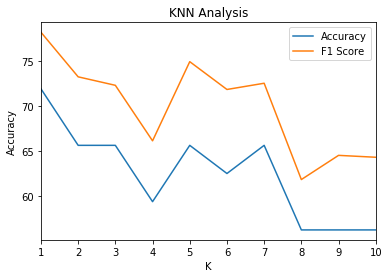

In [25]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state=1)

k_kNN = [(i+1) for i in range(10)]
acc_arr = []
f1_arr = []

for k in k_kNN:
    kNNmodel = KNeighborsClassifier(n_neighbors = k)
    kNNmodel.fit(x_train,y_train)
    yhat_kNN = kNNmodel.predict(x_test)

    acc_arr.append(accuracy_score(y_test,yhat_kNN).round(4)*100)
    f1_arr.append(f1_score(y_test,yhat_kNN, average = 'weighted', labels=np.unique(yhat_kNN)).round(4)*100)

df_dict = {'K':k_kNN,'Accuracy':acc_arr, 'F1 Score':f1_arr}
df_kNN = pd.DataFrame(df_dict)

display(df_kNN)
df_kNN.plot(kind='line',x='K',y=['Accuracy', 'F1 Score'])
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Analysis')
plt.show()


In [81]:
#k = 1 is the best k, Therefore
kNNmodel = KNeighborsClassifier(n_neighbors = 1)
kNNmodel.fit(x_train,y_train)
print('Classification Report :')
print (classification_report(y_test, kNNmodel.predict(x_test)))
print('The cross validation score is : ',cross_val_score(kNNmodel, X, Y, cv=5).mean().round(3))

Classification Report :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       0.75      0.75      0.75         4
           4       0.50      1.00      0.67         1
           5       0.67      1.00      0.80         2
           6       0.50      0.50      0.50         2
           7       0.77      0.91      0.83        11
           8       0.00      0.00      0.00         1
           9       0.67      0.67      0.67         3
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1

   micro avg       0.72      0.72      0.72        32
   macro avg       0.45      0.56      0.49        32
weighted avg       0.62      0.72      0.66        32

T

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [27]:
#Using entire dataset to train the model
kNNmodel = KNeighborsClassifier(n_neighbors = 1)
kNNmodel.fit(X,Y)
yhat_kNN = kNNmodel.predict(X)

<h3> Create a new dataframe for the current neighborhood and its venues</h3>

In [28]:
#Get Latitude and longitude values of current neighborhood
currentNeighName = input()
geolocator = Nominatim(user_agent="t_explorer")
locationCurrent = geolocator.geocode(currentNeighName)
locationCurrent = [locationCurrent.latitude, locationCurrent.longitude]
print(locationCurrent)

Connaught Place, New Delhi
[28.6313827, 77.2197924]


In [29]:
#Create empty dataframe to store the current neighborhood venues
currentColumns = ['Neighborhood', 'Latitude', 'Longitude']
currentColumns.extend(addColumns)
df_current = pd.DataFrame(columns = currentColumns)
df_current

,Neighborhood,Latitude,Longitude,Venue,VLatitude,VLongitude,Category


In [30]:
#Get the current URL
try:
    lat = locationCurrent[0]
    long = locationCurrent[1]
    currentURL = getURL(lat, long)
    results = requests.get(currentURL).json()
    itemsDict = results['response']['groups'][0]['items']
except:
    pass

#Loop over every venue in the neighborhood
for i,item in enumerate(itemsDict):
    try:
        venueName = item['venue']['name']
        vLat = float(item['venue']['location']['lat'])
        vLong = float(item['venue']['location']['lng'])
        category = item['venue']['categories'][0]['name']

        newRow = [currentNeighName, lat, long, venueName, vLat, vLong, category]

        #Append data to the new dataFrame
        df_current = df_current.append(pd.Series(newRow, index = currentColumns), ignore_index = True)
        print(i, end= " ")
        
    except:
        continue



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 

In [31]:
display(df_current.head())
print(df_current.shape)

,Neighborhood,Latitude,Longitude,Venue,VLatitude,VLongitude,Category
0,"Connaught Place, New Delhi",28.631383,77.219792,Connaught Place | कनॉट प्लेस (Connaught Place),28.632731,77.220018,Plaza
1,"Connaught Place, New Delhi",28.631383,77.219792,Wenger's,28.633412,77.218292,Bakery
2,"Connaught Place, New Delhi",28.631383,77.219792,Starbucks,28.632011,77.217731,Coffee Shop
3,"Connaught Place, New Delhi",28.631383,77.219792,Farzi Cafe,28.632581,77.221125,Molecular Gastronomy Restaurant
4,"Connaught Place, New Delhi",28.631383,77.219792,Rajdhani Thali,28.629999,77.220401,Indian Restaurant


(79, 7)


<h3>Convert current neighborhood venues to categorical variables, add columns which are in KMeans model, drop columns which are not</h3>

In [32]:
#Create new dataframe of the current neighborhood categorical Variable 
currentNeigh = pd.get_dummies(df_current[['Category']], prefix="", prefix_sep="")
currentNeigh.insert(0, 'Neighborhood', df_current[['Neighborhood']])
currentNeigh = currentNeigh.groupby('Neighborhood').mean().reset_index()
currentNeigh = currentNeigh.drop('Neighborhood',axis = 1)

torontoVenues = list(df_modeldata.columns)
currentVenues = list(currentNeigh.columns)

dropVenues = [i for i in currentVenues if i not in torontoVenues]
addVenues = [i for i in torontoVenues if i not in currentVenues]

currentNeigh = currentNeigh.drop(dropVenues,axis = 1)
currentNeigh = currentNeigh.join(pd.DataFrame(0, index=currentNeigh.index, columns=addVenues))
currentNeigh = currentNeigh.reindex(sorted(currentNeigh.columns), axis=1)

In [33]:
display(currentNeigh.head())
print(currentNeigh.shape)

,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Warehouse Store,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(1, 353)


<h3>Predict cluster and generate similarity score</h3>

In [34]:
#predict the current neighborhood cluster

similarCluster = kNNmodel.predict(currentNeigh.values)[0]
print('This belongs to cluster : ', similarCluster)

This belongs to cluster :  6


In [35]:
#toronto_Df contains the toronto neighborhoods and their venue categorical variables

neighborslist = list(df2[df2['Cluster'] == similarCluster]['Neighborhood'])

neighbors_df = toronto_df[toronto_df['Neighborhood'].isin(neighborslist)]

neighbors_df = neighbors_df.reset_index(drop=True)

In [36]:
#create new dataframe to store the neighborhood names which belong to current neighborhood cluster
neighbors_names = neighbors_df[['Neighborhood']]

#keep only their categorical variables (of same cluster toronto neighborhoods)
neighbors_df = neighbors_df.drop('Neighborhood', axis = 1)

In [37]:
#create a new dataframe and append the current neighborhood categorical variables as many times as there
#are rows in neighbors_df

current_df = currentNeigh[0:1]

for i in range(len(neighbors_df) - 1):
    current_df = current_df.append(currentNeigh[0:1], ignore_index = True)


In [38]:
#find the correlation between the two dataframes and hence the similarity

neighbors_names['Similarity'] = current_df.corrwith(neighbors_df, axis = 1).round(2)*100
neighbors_names = neighbors_names.sort_values('Similarity', ascending = False).reset_index(drop = True)

In [39]:
#get the top 10 similar neighborhoods and their coordinates
top_10 = (pd.merge(left=neighbors_names, right=df2[['Neighborhood', 'Latitude', 'Longitude']], how='left', left_on='Neighborhood', right_on='Neighborhood')).head(10)
display(top_10)

,Neighborhood,Similarity,Latitude,Longitude
0,Parkdale,57.0,43.640495,-79.436897
1,India Bazaar,55.0,43.672223,-79.323503
2,North Midtown,42.0,43.162128,-77.619604
3,The Junction North,42.0,43.665478,-79.470352
4,Trinity,40.0,43.665302,-79.395252
5,Harbord,39.0,43.661512,-79.414391
6,University of Toronto,38.0,43.663462,-79.397760
7,The Annex,37.0,43.670338,-79.407117
8,South of Bloor,36.0,43.666534,-79.402926
9,Christie,35.0,43.664111,-79.418405


In [40]:
#Plot current neighborhood on map

curMap = folium.Map(location = locationCurrent, zoom_start = 12)
folium.Circle(
    locationCurrent,
    radius = 1000,
    color = '#ffd633',
    opacity = 0.2,
    fill_color = '#ffd633',
    fill_opacity = 0.2,
    ).add_to(curMap)

folium.CircleMarker(
    locationCurrent,
    radius=5,
    popup=currentNeighName,
    color = '#ff3333',
    fill_color = '#ff3333',
    fill_opacity = 1,
    parse_html=False
    ).add_to(curMap)

#Map displayed later

In [41]:
#PLOT the top 10 neighborhoods on map

top10_map = folium.Map(location = locationToronto, zoom_start = 10)
color10 = randomColor()

for neigh, sim, lat, long in zip(top_10['Neighborhood'], top_10['Similarity'], top_10['Latitude'], top_10['Longitude']):
    label = '{} %, {}'.format(sim, neigh)
    
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color = '#FFFFFF',
        weight = 2,
        fill_color = color10,
        fill_opacity = 1,
        parse_html=False).add_to(top10_map)

#Map displayed later

<h3>Plot maps and graphs </h3>

In [42]:
#plot the current Neighborhood
display(curMap)

In [43]:
#plot the neighborhoods and a 1km radius around them
display(map_Toronto)

In [44]:
#plot the clusters on the map of toronto
display(clusters_map)

In [45]:
#Plot the top 10 similar neighborhoods non map
display(top10_map)

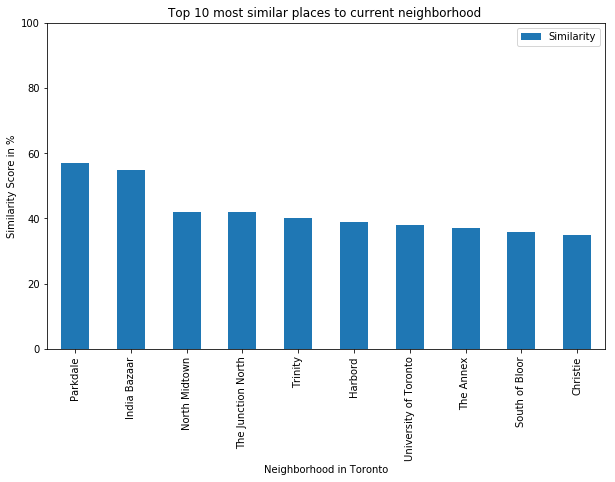

In [46]:
#the top 10 similar neighborhoods on bar plot

top_10.plot(kind = 'bar', x='Neighborhood', y= 'Similarity', figsize=  (10,6))
plt.title('Top 10 most similar places to current neighborhood ')
plt.xlabel('Neighborhood in Toronto')
plt.ylabel('Similarity Score in %')
plt.ylim(0,100)
plt.show()

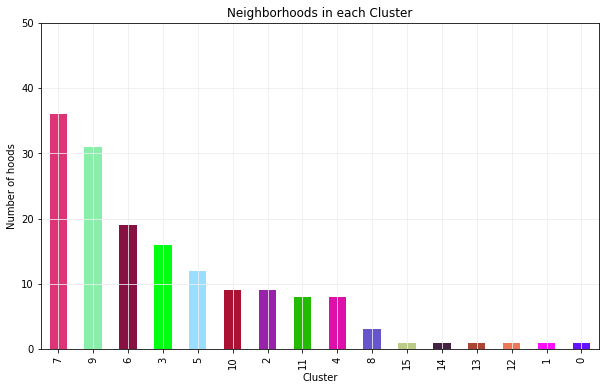

In [47]:
#cluster wise neighborhood distribution in toronto, bar plot

df2['Cluster'].value_counts().plot(kind = 'Bar', stacked = True, color = colors, figsize = (10,6))
plt.title('Neighborhoods in each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of hoods')
plt.ylim(0,50)
plt.grid(color = '#EEEEEE')
plt.show()

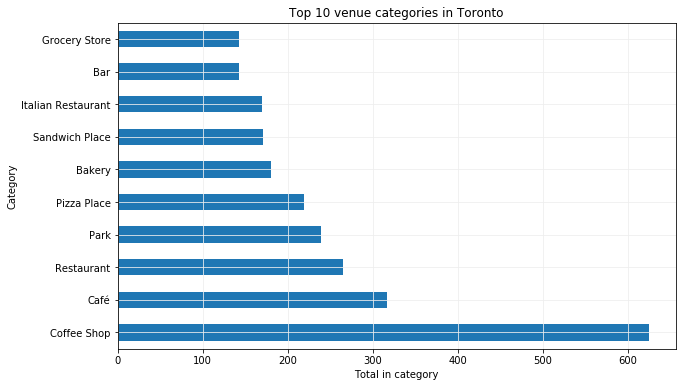

In [48]:
#most popular venues in toronto, bar plot

df3['Category'].value_counts()[0:10].plot(kind = 'Barh', stacked = True, figsize = (10,6))
plt.title('Top 10 venue categories in Toronto')
plt.xlabel('Total in category')
plt.ylabel('Category')
plt.grid(color = '#EEEEEE')
plt.show()

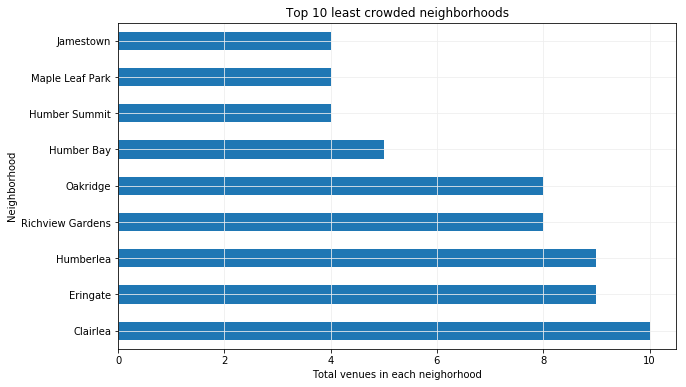

In [49]:
#least crowded neighborhoods in toronto

df3['Neighborhood'].value_counts()[-10:-1].plot(kind = 'Barh', stacked = True, figsize = (10,6))
plt.title('Top 10 least crowded neighborhoods')
plt.xlabel('Total venues in each neighorhood')
plt.ylabel('Neighborhood')
plt.grid(color = '#EEEEEE')
plt.show()

#cannot show most crowded as forsquare only returns 100 venues

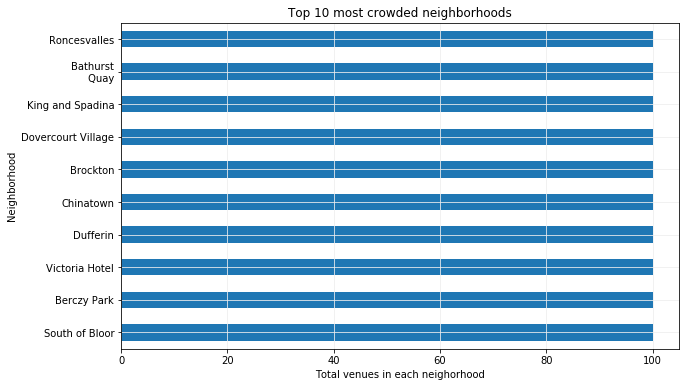

In [50]:
#most crowded neighborhoods in toronto
#foursquare only allows to retrieve top 100 venues

df3['Neighborhood'].value_counts()[0:10].plot(kind = 'Barh', stacked = True, figsize = (10,6))
plt.title('Top 10 most crowded neighborhoods')
plt.xlabel('Total venues in each neighorhood')
plt.ylabel('Neighborhood')
plt.grid(color = '#EEEEEE')
plt.show()